In [1]:
import torch
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 10               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate
DOWNLOAD_MNIST = True   # set to True if haven't download the data

In [3]:
# Mnist digital dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)

torch.Size([60000, 28, 28])
torch.Size([60000])


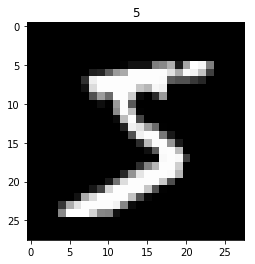

In [4]:
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [5]:
# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy().squeeze()[:2000]    # covert to numpy array

In [6]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

In [7]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [8]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [9]:
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):        # gives batch data
        b_x = b_x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

Epoch:  0 | train loss: 2.2983 | test accuracy: 0.12
Epoch:  0 | train loss: 1.0339 | test accuracy: 0.62
Epoch:  0 | train loss: 0.6460 | test accuracy: 0.73
Epoch:  0 | train loss: 0.6973 | test accuracy: 0.79
Epoch:  0 | train loss: 0.4847 | test accuracy: 0.83
Epoch:  0 | train loss: 0.3174 | test accuracy: 0.89
Epoch:  0 | train loss: 0.3220 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2334 | test accuracy: 0.89
Epoch:  0 | train loss: 0.2366 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1906 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2320 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0950 | test accuracy: 0.94
Epoch:  0 | train loss: 0.4261 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1857 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2306 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2007 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0836 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1191 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0443 | test accuracy

KeyboardInterrupt: 

In [11]:
rnn.out.weight

Parameter containing:
tensor([[ 0.2633,  0.6584,  0.1871,  0.4013,  0.0962,  0.4499, -0.8522,  0.0503,
         -0.1087,  0.1226,  0.3473, -0.4307, -0.2608,  0.4554, -0.2854,  0.2348,
         -1.3658, -0.3349, -0.3948,  0.0371,  1.1289, -0.0988, -0.4447, -0.4712,
          0.0561,  0.0530, -0.0047, -0.6892,  0.3752,  0.5110, -0.3544, -1.2825,
          0.7021, -0.6821,  0.3685,  0.1282, -0.1653,  0.0253, -0.0646,  0.2758,
         -0.0768, -0.9475, -0.1637,  0.7217,  0.6993, -0.0249, -0.7454,  0.5847,
          0.2886,  0.0940, -0.2624, -0.5314, -0.2422,  0.8091,  0.8172,  0.7817,
         -0.4548, -0.4519,  0.9141, -0.6201,  0.5615, -0.7955, -0.2036, -0.1706],
        [-1.7525, -0.5507, -0.7641, -0.0780, -0.6159, -0.5347, -0.6304,  0.1556,
          0.7441,  0.3719,  1.5924, -0.2875,  0.3930,  0.7094,  0.8653, -0.1583,
          0.1747,  0.4373,  0.1138, -0.4036,  0.5774, -1.3483,  0.1043,  0.6092,
          0.0792,  0.1663,  0.8955,  0.4986, -0.0591, -0.7911,  0.5585,  0.0118,
     